# [파이썬 머신러닝 완벽 가이드] <br>
# 05 회귀

## 05-6 규제 선형 모델 = 릿지, 라쏘, 엘라스틱넷 <br>

### [규제 선형 모델의 개요]
- 비용 함수는 학습 데이터의 잔차 오류 값을 최소로 하는 RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 서로 균형을 이뤄야 함<br>
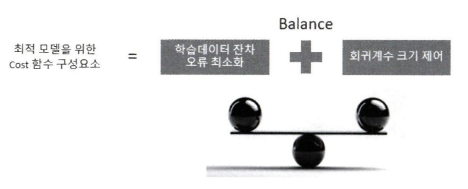
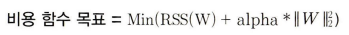 <br>
- `alpha`: 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터
    - alpha가 0 (또는 매우 작은 값)이라면 비용 함수 식은 기존과 동일한 Min(RSS(W)+0)이 됨
    - alpha가 무한대 (또는 매우 큰 값)이라면 비용 함수 식은 RSS(W)에 비해 alpha*||W||^2값이 너무 커지게 되므로 W 값을 0 (또는 매우 작게)으로 만들어야 Cost가 최소화되는 비용 함수 목표를 달성할 수 있음
    - → alpha 값을 크게 하면 비용 함수는 회귀 계수 W의 값을 작게 해 과적합을 개선할 수 있으며, alpha 값을 작게 하면 회귀 계수 W의 값이 커져도 어느정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선할 수 있음 <br>
    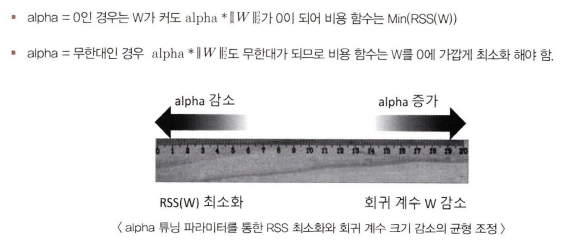 <br>
- 비용 함수에 alpha 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제 (Regularization)이라고 부름
- 규제는 크게 L2 방식과 L1 방식으로 구분됨
    - `L2 규제`는 alpha*||W||^2와 같이 W의 제곱에 대해 페널티를 부여하는 방식을 말하며 L2 규제를 적용한 회귀를 `릿지(Ridge)` 회귀라고 함
    - `L1 규제`는 alpha*||W||와 같이 W의 절댓값에 대해 페널티를 부여하는 방식을 말하며 L1 규제를 적용한 회귀를 `라쏘(Lasso)` 회귀라고 함
    - L1 규제를 적용하면 영향력이 크지 않은 회귀 계수 값을 0으로 변환함

### [릿지 회귀]
- W의 제곱에 대해 페널티를 부여하는 L2 규제를 적용한 회귀
- Ridge 클래스의 주요 생성 파라미터는 alpha이며 이는 릿지 회귀의 alpha L2 규제 계수에 해당됨

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston

#boston 데이터 세트 로드
boston = load_boston()

#boston 데이터 세트 DataFrame 반환
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

#boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함
bostonDF['PRICE'] = boston.target

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

#alpha=10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores,3))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores,3))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE: 5.518


In [21]:
#릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0,0.1,1,10,100]

#alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    
    #cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0}일 때 5 folds의 평균 RMSE: {1:.3f}'.format(alpha,avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE: 5.829
alpha 0.1일 때 5 folds의 평균 RMSE: 5.788
alpha 1일 때 5 folds의 평균 RMSE: 5.653
alpha 10일 때 5 folds의 평균 RMSE: 5.518
alpha 100일 때 5 folds의 평균 RMSE: 5.330


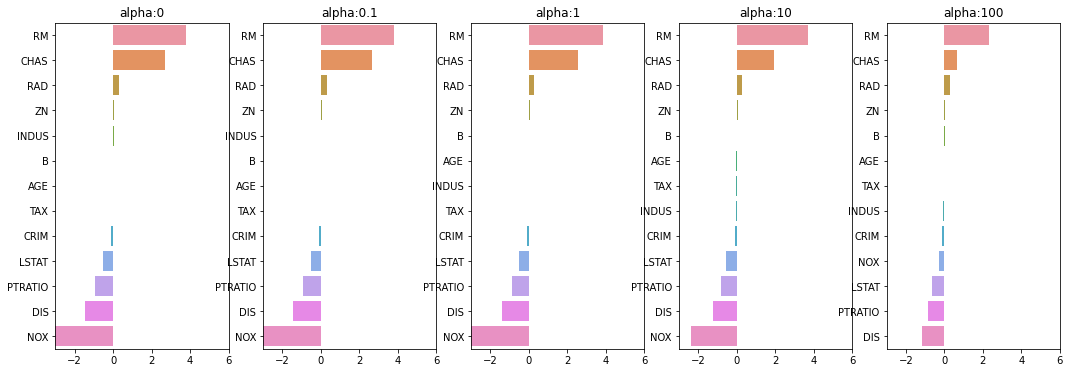

In [25]:
#각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)
#각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

#alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    
    #alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    
    #막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])
    
#for문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

#alpha 값을 계속 증가시킬수록 회귀 계수 값은 지속적으로 작아짐

In [26]:
ridge_alphas = [0,0.1,1,10,100]
sort_column = 'alpha:' + str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

#alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있지만 릿지 회귀의 경우에는 회귀 계수를 0으로 만들지는 않음

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


### [라쏘 회귀]
- W의 절댓값에 대해 페널티를 부여하는 L1 규제를 적용한 회귀
- 라쏘 회귀 비용함수의 목표는 RSS(W) + alpha*||W|| 식을 최소화하는 W를 찾는 것임
- L2 규제가 회귀 계수의 크기를 감소시키는 데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거함
- L1 규제는 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가지고 있음
- Lasso 클래스의 주요 생성 파라미터는 alpha이며 이는 라쏘 회귀의 alpha L1 규제 계수에 해당함

In [29]:
from sklearn.linear_model import Lasso, ElasticNet

#alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose: print('######', model_name, '######')
    for param in params:
        if model_name == 'Ridge': model = Ridge(alpha=param)
        elif model_name == 'Lasso': model = Lasso(alpha=param)
        elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
        
        #corss_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data, y_target)
    
        #alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
        coeff = pd.Series(data=model.coef_, index=X_data.columns)
        colname = 'alpha:'+str(param)
        coeff_df[colname] = coeff
    return coeff_df
#end of get_linear_reg_eval

In [31]:
#라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_lienar_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#alpha가 0.07일 때 가장 좋은 평균 RMSE를 보여줌

###### Lasso ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


In [34]:
#변환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

#alpha의 크기가 증가함에 따라 일부 피처의 회귀 계수는 아예 0으로 바뀌고 있음
#회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있음

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


### [엘라스틱넷 회귀]
- 엘라스틱넷 (Elastic Net) 회귀는 L2 규제와 L1 규제를 결합한 회귀임
- 엘라스틱넷 회귀 비용함수의 목표는 RSS(W) + alpha2 x ||W||^2 + alpha1 x ||W|| 식을 최소화하는 W를 찾는 것임
- 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우에 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강한데, 이러한 성향으로 인해 alpha 값에 따라 회귀 계수의 값이 급격히 변동할 수 있음
- 엘라스틱넷 회귀는 이를 완화하기 위해 L2 규제를 라쏘 회귀에 추가한 것임
- 엘라스틱넷 회귀는 L1과 L2 규제가 결합된 규제로 인해 수행시간이 상대적으로 오래 걸림 
<br><br>
- ElasticNet 클래스의 주요 생성 파라미터는 alpha와 l1_ratio임
- ElasticNet 클래스의 alpha는 Ridge와 Lasso 클래스의 alpha값과는 다름
- 엘라스틱넷의 규제는 a x L1 + b x L2로 정의될 수 있음 (a: L1 규제의 alpha 값, b: L2 규제의 alpha 값)
- ElasticNet 클래스의 l1_ratio 파라미터 값: a / (a+b)
- l1_ratio가 0이면 a가 0이므로 L2 규제와 동일하고 1이면 b가 0이므로 L1 규제와 동일함

In [36]:
#엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
#l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

###### ElasticNet ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [39]:
#반환된 coeff_elastic_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

#alpha가 0.5일 때 가장 좋은 성능 예측을 보임
#alpha값에 따른 피처들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적음

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


### [선형 회귀 모델을 위한 데이터 반환]
- 타깃값의 경우 정규 분포 형태가 아니라 특정값의 분포가 치우친 왜곡(skew)된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높으므로 선형 회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적임
<br><br>

#### 사이킷런을 이용해 피처 데이터 세트에 적용하는 변환 작업
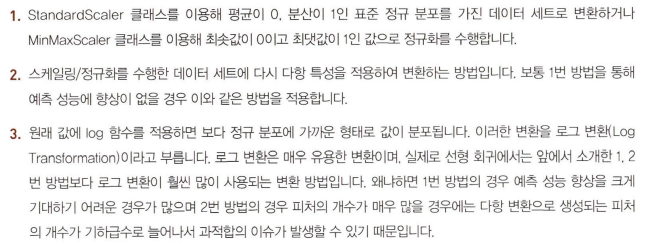
- 왜곡된 분포도 형태의 타깃값ㅇ르 로그 변환하여 예측 성능 향상이 된 경우가 많은 사례에서 검증되었기 때문에 타깃값의 경우는 `로그 변환`을 적용함

In [53]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

#method는 표준 정규 분포 변환 (Standard), 최댓값/최솟값 정규화 (MinMax), 로그변환 (Log) 결정
#p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2 이상 부여하지 않음
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data) #1 + log() 함수 적용
    else:
        scaled_data = input_data
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
        
    return scaled_data

In [55]:
#Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

#5개 방식으로 변환. 먼저 원본 그대로, 표준정규 분포, 표준정규 분포 + 다항식 특성
#최대/최소 정규화, 최대/최소 정규화 + 다항식 특성, 로그 변환
scale_methods = [(None,None), ('Standard', None), ('Standard',2), ('MinMax',None), ('MinMax',2), ('Log',None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
    print('\n## 변환 유형: {0}, Polynomial Degree: {1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False)
    
#로그 변환을 보면 alpha가 0.1, 1, 10인 경우에 모두 좋은 성능 향상이 있음


## 변환 유형: None, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형: Standard, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환 유형: Standard, Polynomial Degree: 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634

## 변환 유형: MinMax, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635

## 변환 유형: MinMax, Polynomial Degree: 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538

## 변환 유형: Log, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균

## 05-7 로지스틱 회귀 <br>
- 로지스틱 회귀는 선형 회귀 방식을 분류에 적용한 알고리즘으로 분류에 사용됨
- 회귀가 선형인가 비선현인가는 독립변수가 아닌 가중치(weight) 변수가 선형인지 아닌지를 따름
- 로지스틱 회귀가 선형 회귀와 다른 점은 학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아니라 시그모이드 (Sigmoid) 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정한다는 것임 <br>
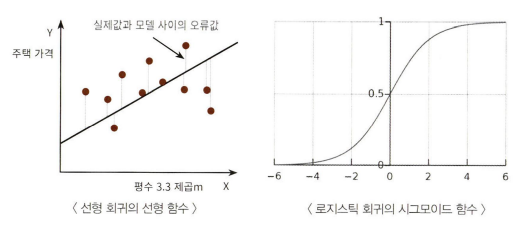 <br>
- 시그모이드 함수: y = 1 / ( 1 + exp(-x) )
    - 시그모이드 함수는 x값이 +, -로 아무리 커지거나 작아져도 y값은 항상 0과 1 사이의 값을 반환함
    - x값이 커지면 1에 근사하며 x값이 작아지면 0에 근사하고 x가 0일 때는 0.5임

- 종양의 크기에 따라 악성 종양인지 (Yes=1) 그렇지 않은지 (No=0)를 회귀를 적용해 1과 0의 값으로 예측
- S자 커브 형태의 시그모이드 함수를 이용하면 좀 더 정확하게 0과 1에 대해 분류를 할 수 있음 <br>
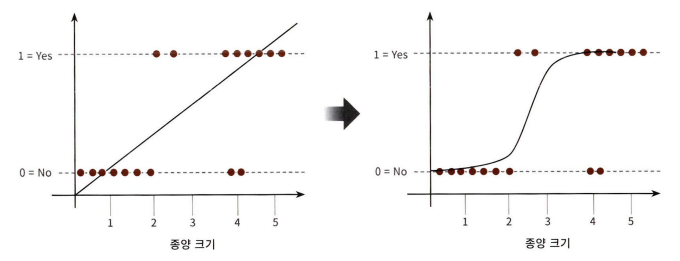

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#StandardScaler()로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [58]:
from sklearn.metrics import accuracy_score, roc_auc_score

#로지스틱 회귀를 이용해 학습 및 예측 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

#정확도와 roc_auc 측정
print('accuracy: {0:.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {0:.3f}'.format(roc_auc_score(y_test, lr_preds)))

accuracy: 0.977
roc_auc: 0.972


- 사이킷런 LogisticRegression 클래스의 주요 하이퍼 파라미터: penalty, C
- penalty는 규제(Regularization)의 유형을 설정하며 'l2'로 설정 시 L2 규제를, 'l1'으로 설정 시 L1 규제를 뜻함 (default: 'l2')
- C는 규제 강도를 조절하는 alpha 값의 역수로 C값이 작을수록 규제 강도가 큼

In [62]:
from sklearn.model_selection import GridSearchCV

params = {'penalty':['l2','l1'],
         'C':[0.01,0.1,1,5.10]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터: {0}, 최적 평균 정확도: {1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

#로지스틱 회귀는 가볍과 빠르지만 이진 분류 예측 성능도 뛰어나기 때문에 로지스틱 회귀를 이진 분류의 기본 모델로 사용하는 경우가 많음
#또한 희소한 데이터 세트 분류에도 뛰어난 성능을 보여서 텍스트 분류에서도 자주 사용됨

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_v

최적 하이퍼 파라미터: {'C': 1, 'penalty': 'l2'}, 최적 평균 정확도: 0.975


## 05-8 회귀 트리 <br>
- 데이터 세트의 X 피처를 결정 트리 기반으로 분할하여 X값의 균일도를 반영한 지니 계수에 따라 다음과 같이 분할함 <br>
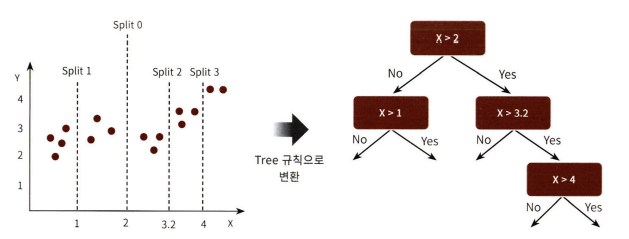 <br>
- 리프 노드 생성 기준에 부합하는 트리 분할이 완료됐다면 리프 노드에 소속된 데이터 값의 평균 값을 구해서 최종적으로 리프 노드에 결정값으로 할당함 <br>
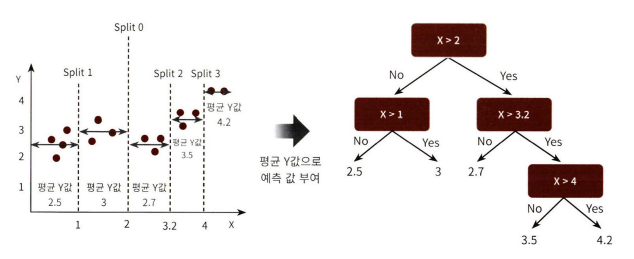 <br><br>

- 트리 생성이 CART (Classification And Regression Trees) 알고리즘에 기반하고 있기  때문에 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등 모든 트리 기반의 알고리즘은 분류 뿐만이 아니라 회귀도 가능함 <br>
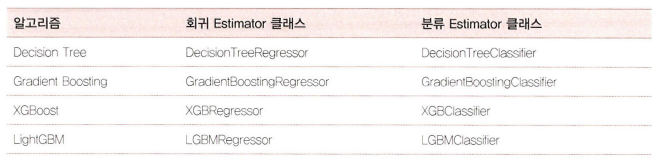

In [69]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

#보스턴 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores:', np.round(neg_mse_scores,2))
print('5 교차 검증의 개별 RMSE scores:', np.round(rmse_scores,2))
print('5 교차 검증의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 교차 검증의 개별 Negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores: [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE: 4.423


In [74]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('#### ', model.__class__.__name__, ' ####')
    print('5 교차 검증의 평균 RMSE: {0:.3f}\n'.format(avg_rmse))

In [75]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

#트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

####  DecisionTreeRegressor  ####
5 교차 검증의 평균 RMSE: 5.978

####  RandomForestRegressor  ####
5 교차 검증의 평균 RMSE: 4.423

####  GradientBoostingRegressor  ####
5 교차 검증의 평균 RMSE: 4.269

####  XGBRegressor  ####
5 교차 검증의 평균 RMSE: 4.251

####  LGBMRegressor  ####
5 교차 검증의 평균 RMSE: 4.646



<AxesSubplot:>

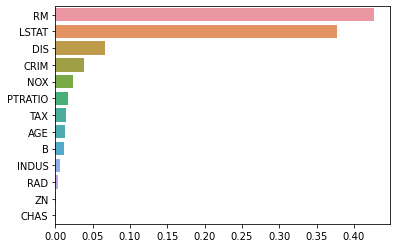

In [76]:
#피처별 중요도 시각화

import seaborn as sns

rf_reg = RandomForestRegressor(n_estimators=1000)

#앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습함
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

(100, 2)


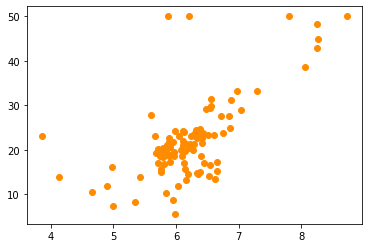

In [78]:
#회귀 트리 Regressor가 어떻게 예측값을 판단하는지 선형 회귀와 비교해 시각화

bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')

In [79]:
import numpy as np
from sklearn.linear_model import LinearRegression

#선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

#실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개 데이터 세트로 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1,1)

#보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

#학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

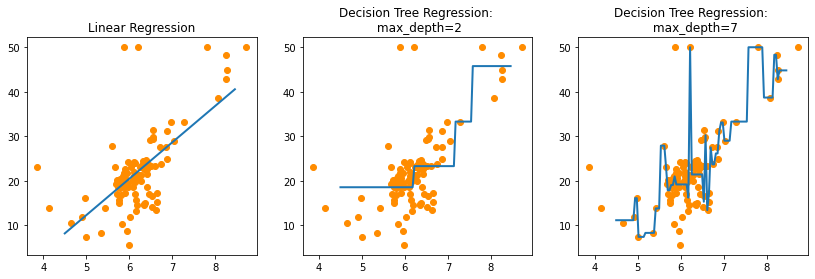

In [81]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

#X축 값을 4.5~8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
#선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

#DecisionTreeRegressor의 max_depth를 2로 했을 때 예측 회귀선
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth:2', linewidth=2)

#DecisionTreeRegressor의 max_depth를 7로 했을 때 예측 회귀선
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)

- 선형 회귀는 직선으로 예측 회귀선을 표현하는 데 반해, 회귀 트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선을 만듦
- DecisionTreeRegressor의 max_depth=7인 경우에는 학습 데이터 세트의 이상치 (outlier) 데이터도 학습하면서 복잡한 계단 형태의 회귀선을 만들어 과적합이 되기 쉬운 모델이 되었음